Copy of 9 with different output for charge and PID

In [1]:
AEversion = '10'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Tue Jul 16 08:25:56 2019
[0] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 58'C,  81 % |  2586 /  8119 MB | ocerri(2575M)
[2] GeForce GTX 1080 | 34'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=50, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [19]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p+3+2+4)*self.No,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p+3+2+4)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        sig_pt = 1. + 1e-6 + F.elu(x_raw[:,:,1]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,2], min_val=-5, max_val=5).view(-1, self.No, 1)
        sig_eta = 1. + 1e-6 + F.elu(x_raw[:,:,3]).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,4]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        sig_phi = 1. + 1e-6 + F.elu(x_raw[:,:,5]).view(-1, self.No, 1)
        # charge
        charge_cat = ELU_ProbNorm(x_raw[:,:,6:9])
        # pId
        pId_cat = ELU_ProbNorm(x_raw[:,:,9:])
        
        x = torch.cat((pt, eta, phi, sig_pt, sig_eta, sig_phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            os.environ['CUDA_VISIBLE_DEVICES'] = str(N_GPU)
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [20]:
Latent_dimension = int(0.3*dataset.inputs.shape[1])
Hidden_dimension = int(0.25*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=250, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=66, bias=True)
      (3): ReLU()
      (4): Linear(in_features=66, out_features=15, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (PhiD): Sequential(
      (0): Linear(in_features=15, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=66, bias=True)
      (3): ReLU()
      (4): Linear(in_features=66, out_features=700, bias=True)
    )
  )
)

Trainable parameters: 74371


In [21]:
model.useGPU(int(AEversion)%8)

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Tue Jul 16 08:31:13 2019
[0] GeForce GTX 1080 | 22'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 56'C,  10 % |  2586 /  8119 MB | ocerri(2575M)
[2] GeForce GTX 1080 | 27'C,   0 % |   677 /  8119 MB | ocerri(667M)
[3] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |


## Loss

In [22]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    out_gauss = 0.5*torch.pow((x_in[:,:,:3] - x_out[:,:,:3])/ x_out[:,:,3:6], 2) + torch.log(x_out[:,:,3:6])
    out = torch.sum(out_gauss, dim=2)
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,6:9]).view(-1, 3)
    aux = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none')
    out += aux.view(-1, x_in.shape[1])
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,9:14]).view(-1, 5)
    out += F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1])
    
    out_per_evt = torch.sum(out, dim=1)
    
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [23]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 1000

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [24]:
# torch.autograd.set_detect_anomaly(True);

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [26]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)        
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        aux_loss = 0
        N_batches = 0
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            aux_loss += loss.item()
            N_batches += 1
        batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])
        
        #### ---- Periodic save model ---- ####
        if epoch%50 == 0:
            torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_epoch{}.pkl'.format(epoch))

        #### ---- Anomaly Detection monitor ---- ####
        if epoch%3 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 17.1 s           
Loss: 5.99e+01
Val Loss: 6.01e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.31e-04 | 4.44e-03 | 3.04e-02 |
| leptoquark | 8.41e-05 | 1.02e-03 | 1.06e-02 |
| hToTauTau  | 4.69e-04 | 3.56e-03 | 2.46e-02 |
| hChToTauNu | 7.06e-04 | 4.89e-03 | 3.07e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 17.4 s                       
Loss: 4.69e+01 - Delta: -1.30e+01
Val Loss: 4.71e+01

Epoch 2: [####################] 

Val Loss: 1.35e+01

Epoch 21: [####################]  100% - Tot. time: 17.6 s                       
Loss: 2.52e+01 - Delta: 1.19e+01 - Trend: 2.61e+01
Val Loss: 2.54e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 25.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.82e-04 | 1.28e-02 |
| leptoquark | 4.02e-05 | 9.43e-04 | 1.32e-02 |
| hToTauTau  | 3.43e-04 | 3.63e-03 | 2.99e-02 |
| hChToTauNu | 5.64e-04 | 6.03e-03 | 4.27e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 22: [####################]  100% - Tot. time: 17.4 s                       
Loss: 1.24e+01 -

Epoch 40: [####################]  100% - Tot. time: 28.2 s                       
Val Loss: 6.13e-01

Epoch 42: [####################]  100% - Tot. time: 27.9 s                       
Loss: 1.56e+01 - Delta: 1.51e+01 - Trend: 1.54e+01
Val Loss: 1.57e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 29.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 1.2 s
hToTauTau: [##############]  100% - Tot. time: 5.1 s
hChToTauNu: [#######]  100% - Tot. time: 2.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.68e-04 | 1.74e-03 | 1.79e-02 |
| leptoquark | 5.48e-05 | 7.97e-04 | 1.20e-02 |
| hToTauTau  | 1.51e-04 | 2.66e-03 | 3.02e-02 |
| hChToTauNu | 2.25e-04 | 4.25e-03 | 4.27e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 43: [#####

Epoch 61: [####################]  100% - Tot. time: 28.7 s                        
Loss: -2.55e+00 - Delta: -5.08e-02 - Trend: 6.11e-01
Val Loss: -2.38e+00

Epoch 62: [####################]  100% - Tot. time: 29.3 s                        
Loss: -2.63e+00 - Delta: -8.53e-02 - Trend: -3.45e-02
Val Loss: -2.47e+00

Epoch 63: [####################]  100% - Tot. time: 28.7 s                        
Loss: -3.31e+00 - Delta: -6.76e-01 - Trend: -5.90e-01
Val Loss: -3.15e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 29.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 1.1 s
hToTauTau: [##############]  100% - Tot. time: 5.1 s
hChToTauNu: [#######]  100% - Tot. time: 2.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.08e-04 | 1.74e-03 | 2.41e-02 |
| leptoquark | 1.57e-04 | 1.51e-03 | 1.65e-0

Epoch 82: [####################]  100% - Tot. time: 17.8 s                        
Loss: -6.67e+00 - Delta: -5.98e+00 - Trend: -1.19e+01
Val Loss: -6.52e+00

Epoch 83: [####################]  100% - Tot. time: 20.5 s                        
Loss: -6.42e+00 - Delta: 2.55e-01 - Trend: 6.23e+00
Val Loss: -6.26e+00

Epoch 84: [####################]  100% - Tot. time: 17.8 s                        
Loss: -7.04e+00 - Delta: -6.19e-01 - Trend: -8.75e-01
Val Loss: -6.88e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 5.66e-04 | 2.49e-03 | 3.08e-02 |
| leptoquark | 2.85e-04 | 2.01e-03 | 1.92e-02

Epoch 103: [####################]  100% - Tot. time: 17.6 s                        
Loss: -8.13e+00 - Delta: 1.82e+00 - Trend: 2.60e+00
Val Loss: -7.98e+00

Epoch 104: [####################]  100% - Tot. time: 20.4 s                        
Loss: -8.88e+00 - Delta: -7.46e-01 - Trend: -2.57e+00
Val Loss: -8.73e+00

Epoch 105: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.03e+01 - Delta: -1.45e+00 - Trend: -7.00e-01
Val Loss: -1.02e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.76e-04 | 4.05e-03 | 4.09e-02 |
| leptoquark | 4.31e-04 | 2.54e-03 | 2.13e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 214: [####################]  100% - Tot. time: 17.4 s                        
Loss: -1.57e+01 - Delta: 6.75e-02 - Trend: 8.43e-02
Val Loss: -1.56e+01

Epoch 215: [####################]  100% - Tot. time: 17.5 s                        
Loss: -1.58e+01 - Delta: -9.49e-02 - Trend: -1.62e-01
Val Loss: -1.56e+01

Epoch 216: [####################]  100% - Tot. time: 17.3 s                        
Loss: 2.18e+00 - Delta: 1.80e+01 - Trend: 1.81e+01
Val Loss: 2.32e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.76e-03 | 9.39e-03 | 4.35e-02 |
| leptoquark | 3.51e-04 | 2.46e-03 | 1.89e-02 

Epoch 235: [####################]  100% - Tot. time: 17.6 s                        
Loss: -1.65e+01 - Delta: -5.32e-02 - Trend: 5.90e-02
Val Loss: -1.63e+01

Epoch 236: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.64e+01 - Delta: 3.67e-02 - Trend: 8.99e-02
Val Loss: -1.63e+01

Epoch 237: [####################]  100% - Tot. time: 20.2 s                        
Loss: -1.66e+01 - Delta: -1.23e-01 - Trend: -1.59e-01
Val Loss: -1.64e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.17e-03 | 7.71e-03 | 3.85e-02 |
| leptoquark | 2.41e-04 | 2.12e-03 | 1.91e-

Epoch 256: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.69e+01 - Delta: -9.07e-01 - Trend: -1.80e+00
Val Loss: -1.68e+01

Epoch 257: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.70e+01 - Delta: -2.50e-02 - Trend: 8.82e-01
Val Loss: -1.68e+01

Epoch 258: [####################]  100% - Tot. time: 20.1 s                        
Loss: -1.70e+01 - Delta: 1.25e-02 - Trend: 3.75e-02
Val Loss: -1.68e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.07e-03 | 6.88e-03 | 3.66e-02 |
| leptoquark | 2.34e-04 | 1.78e-03 | 1.84e-

Epoch 277: [####################]  100% - Tot. time: 17.6 s                        
Loss: -1.72e+01 - Delta: -3.55e-02 - Trend: -6.46e-02
Val Loss: -1.70e+01

Epoch 278: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.72e+01 - Delta: -1.82e-03 - Trend: 3.36e-02
Val Loss: -1.70e+01

Epoch 279: [####################]  100% - Tot. time: 20.8 s                        
Loss: -1.68e+01 - Delta: 3.91e-01 - Trend: 3.93e-01
Val Loss: -1.66e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.07e-03 | 6.77e-03 | 3.65e-02 |
| leptoquark | 2.49e-04 | 1.80e-03 | 1.86e-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 9.01e-04 | 5.20e-03 | 3.40e-02 |
| leptoquark | 1.79e-04 | 1.28e-03 | 1.67e-02 |
| hToTauTau  | 2.26e-04 | 1.54e-03 | 3.69e-02 |
| hChToTauNu | 3.60e-04 | 2.33e-03 | 5.19e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 313: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.76e+01 - Delta: -2.29e+00 - Trend: -4.62e+00
Val Loss: -1.74e+01

Epoch 314: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.77e+01 - Delta: -1.01e-01 - Trend: 2.19e+00
Val Loss: -1.75e+01

Epoch 315: [####################]  100% - Tot. time: 19.6 s                        
Loss: -1.77e+01 - Delta: 9.02e-04 - Trend: 1.02e-01
Val Loss: -1.75e+01

------------ Anomaly Detection monitor --

SM Mix: [####################]  100% - Tot. time: 20.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.92e-04 | 3.88e-03 | 3.13e-02 |
| leptoquark | 1.61e-04 | 1.04e-03 | 1.59e-02 |
| hToTauTau  | 2.13e-04 | 1.21e-03 | 3.60e-02 |
| hChToTauNu | 3.10e-04 | 1.79e-03 | 5.07e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 334: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.76e+01 - Delta: 2.46e-01 - Trend: 5.46e-01
Val Loss: -1.74e+01

Epoch 335: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.77e+01 - Delta: -1.22e-01 - Trend: -3.68e-01
Val Loss: -1.76e+01

Epoch 3

SM Mix: [####################]  100% - Tot. time: 20.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.08e-04 | 3.37e-03 | 3.00e-02 |
| leptoquark | 1.35e-04 | 9.58e-04 | 1.55e-02 |
| hToTauTau  | 1.99e-04 | 1.11e-03 | 3.52e-02 |
| hChToTauNu | 2.87e-04 | 1.62e-03 | 4.97e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 355: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.80e+01 - Delta: -1.10e-02 - Trend: -1.35e-02
Val Loss: -1.78e+01

Epoch 356: [####################]  100% - Tot. time: 18.5 s                        
Loss: -1.80e+01 - Delta: 3.34e-04 - Trend: 1.14e-02
Val Loss: -1.78e+01

Epoch 3

leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.08e-04 | 2.98e-03 | 2.97e-02 |
| leptoquark | 1.32e-04 | 8.95e-04 | 1.51e-02 |
| hToTauTau  | 1.91e-04 | 1.03e-03 | 3.42e-02 |
| hChToTauNu | 2.81e-04 | 1.47e-03 | 4.84e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


hChToTauNu: [#######]  100% - Tot. time: 1.2 s  15 s   Loss: -1.82e+01 (-1.35e-01)hChToTauNu: [-------]  0%
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 5.03e-04 | 2.49e-03 | 2.89e-02 |
| leptoquark | 9.50e-05 | 8.08e-04 | 1.48e-02 |
| hToTauTau  | 1.55e-04 | 9.39e-04 | 3.36e-02 |
| hChToTauNu | 2.60e

Epoch 424: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.83e+01 - Delta: -8.65e-03 - Trend: -1.44e-02
Val Loss: -1.81e+01

Epoch 425: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.83e+01 - Delta: 2.46e-03 - Trend: 1.11e-02
Val Loss: -1.81e+01

Epoch 426: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.83e+01 - Delta: -3.53e-03 - Trend: -5.99e-03
Val Loss: -1.81e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 23.2 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.39e-03 | 2.88e-02 |
| leptoquark | 9.14e-05 | 7.97e-04 | 1.48e

Epoch 466: [####################]  100% - Tot. time: 19.0 s                        
Loss: -1.83e+01 - Delta: 1.68e-03 - Trend: 3.76e-03
Val Loss: -1.81e+01

Epoch 467: [####################]  100% - Tot. time: 18.2 s                        
Loss: -1.83e+01 - Delta: -4.68e-03 - Trend: -6.36e-03
Val Loss: -1.81e+01

Epoch 468: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.83e+01 - Delta: 2.64e-03 - Trend: 7.32e-03
Val Loss: -1.81e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.6 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.28e-03 | 2.87e-02 |
| leptoquark | 9.14e-05 | 8.11e-04 | 1.46e-0

Epoch 487: [####################]  100% - Tot. time: 20.7 s                        
Loss: -1.83e+01 - Delta: 8.37e-03 - Trend: 1.11e-02
Val Loss: -1.81e+01

Epoch 488: [###########---------]  56% - ETA:    8 s   Loss: -1.82e+01 (1.41e-01))Loss: -1.83e+01 - Delta: -4.01e-03 - Trend: -1.72e-03
Val Loss: -1.81e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.6 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.26e-03 | 2.86e-02 |
| leptoquark | 9.14e-05 | 7.97e-04 | 1.46e-02 |
| hToTauTau  | 1.45e-04 | 9.24e-04 | 3.32e-02 |
| hChToTauNu | 2.36e-04 | 1.25e-03 | 4.72e-02 |
+------------+----------+----------+----------+
-----------

hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.22e-03 | 2.86e-02 |
| leptoquark | 8.77e-05 | 7.86e-04 | 1.46e-02 |
| hToTauTau  | 1.45e-04 | 9.12e-04 | 3.33e-02 |
| hChToTauNu | 2.36e-04 | 1.24e-03 | 4.72e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 511: [####################]  100% - Tot. time: 20.5 s                        
Loss: -1.83e+01 - Delta: 1.29e-03 - Trend: 6.31e-04
Val Loss: -1.82e+01

Epoch 512: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.84e+01 - Delta: -4.08e-03 - Trend: -5.37e-03
Val Loss: -1.82e+01

Epoch 513: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.84e+01 - Delta: 3.91e-04 - Trend: 4.47e-03
Val Loss: 

Val Loss: -1.82e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.7 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.22e-03 | 2.85e-02 |
| leptoquark | 9.14e-05 | 7.82e-04 | 1.46e-02 |
| hToTauTau  | 1.45e-04 | 9.08e-04 | 3.33e-02 |
| hChToTauNu | 2.30e-04 | 1.22e-03 | 4.72e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 532: [####################]  100% - Tot. time: 18.7 s                        
Loss: -1.84e+01 - Delta: -2.71e-03 - Trend: -3.89e-03
Val Loss: -1.82e+01

Epoch 533: [####################]  100% - Tot. time: 17.8 s                        
Loss: -

Epoch 551: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.84e+01 - Delta: 1.59e-03 - Trend: -2.01e-03
Val Loss: -1.82e+01

Epoch 552: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.84e+01 - Delta: -7.21e-03 - Trend: -8.80e-03
Val Loss: -1.82e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.61e-04 | 2.22e-03 | 2.85e-02 |
| leptoquark | 8.77e-05 | 7.75e-04 | 1.46e-02 |
| hToTauTau  | 1.45e-04 | 8.98e-04 | 3.32e-02 |
| hChToTauNu | 2.30e-04 | 1.22e-03 | 4.71e-02 |
+------------+----------+----------+----------+
--------

Epoch 571: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.84e+01 - Delta: 1.62e-03 - Trend: 2.28e-03
Val Loss: -1.82e+01

Epoch 572: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.84e+01 - Delta: -3.03e-03 - Trend: -4.65e-03
Val Loss: -1.82e+01

Epoch 573: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.84e+01 - Delta: -2.16e-04 - Trend: 2.82e-03
Val Loss: -1.82e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [###########---]  78% - ETA:    1 s   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 661: [####################]  100% - Tot. time: 18.8 s                        
Loss: -1.84e+01 - Delta: 9.76e-05 - Trend: 3.13e-04
Val Loss: -1.82e+01

Epoch 662: [####################]  100% - Tot. time: 21.0 s                        
Loss: -1.84e+01 - Delta: -2.79e-04 - Trend: -3.77e-04
Val Loss: -1.82e+01

Epoch 663: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.84e+01 - Delta: -1.51e-03 - Trend: -1.24e-03
Val Loss: -1.82e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.6 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.61e-04 | 2.16e-03 | 2.83e-02 |
| leptoquark | 8.41e-05 | 7.68e-04 | 1.45e

Epoch 682: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.85e+01 - Delta: -2.49e-04 - Trend: -2.59e-03
Val Loss: -1.83e+01

Epoch 683: [####################]  100% - Tot. time: 19.6 s                        
Loss: -1.85e+01 - Delta: -1.39e-03 - Trend: -1.15e-03
Val Loss: -1.83e+01

Epoch 684: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.85e+01 - Delta: -2.36e-03 - Trend: -9.64e-04
Val Loss: -1.83e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.2 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.61e-04 | 2.16e-03 | 2.82e-02 |
| leptoquark | 8.41e-05 | 7.60e-04 | 1.4

Epoch 703: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.85e+01 - Delta: 3.87e-03 - Trend: 4.14e-03
Val Loss: -1.83e+01

Epoch 704: [####################]  100% - Tot. time: 18.6 s                        
Loss: -1.85e+01 - Delta: -5.34e-03 - Trend: -9.22e-03
Val Loss: -1.83e+01

Epoch 705: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.85e+01 - Delta: -5.43e-04 - Trend: 4.80e-03
Val Loss: -1.83e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.61e-04 | 2.16e-03 | 2.83e-02 |
| leptoquark | 8.04e-05 | 7.53e-04 | 1.45e-

Epoch 724: [####################]  100% - Tot. time: 18.8 s                        
Loss: -1.85e+01 - Delta: -2.62e-03 - Trend: -3.98e-03
Val Loss: -1.83e+01

Epoch 725: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.85e+01 - Delta: -1.67e-03 - Trend: 9.57e-04
Val Loss: -1.83e+01

Epoch 726: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.85e+01 - Delta: -4.59e-04 - Trend: 1.21e-03
Val Loss: -1.83e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.6 s
hChToTauNu: [#######]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.40e-04 | 2.16e-03 | 2.82e-02 |
| leptoquark | 8.04e-05 | 7.53e-04 | 1.45e

KeyboardInterrupt: 

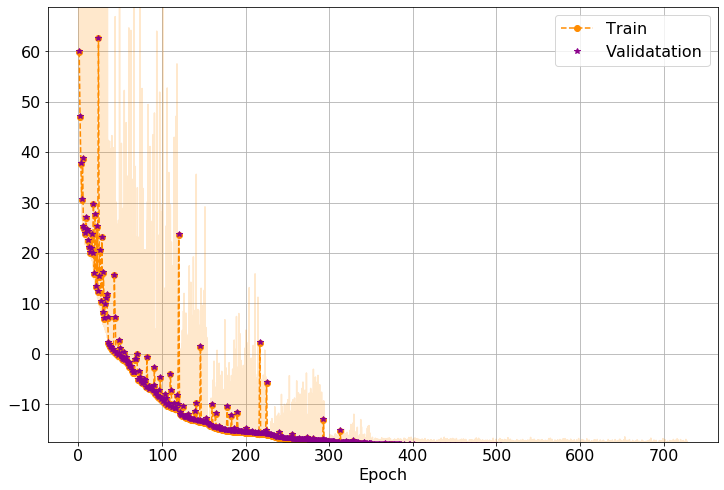

In [27]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

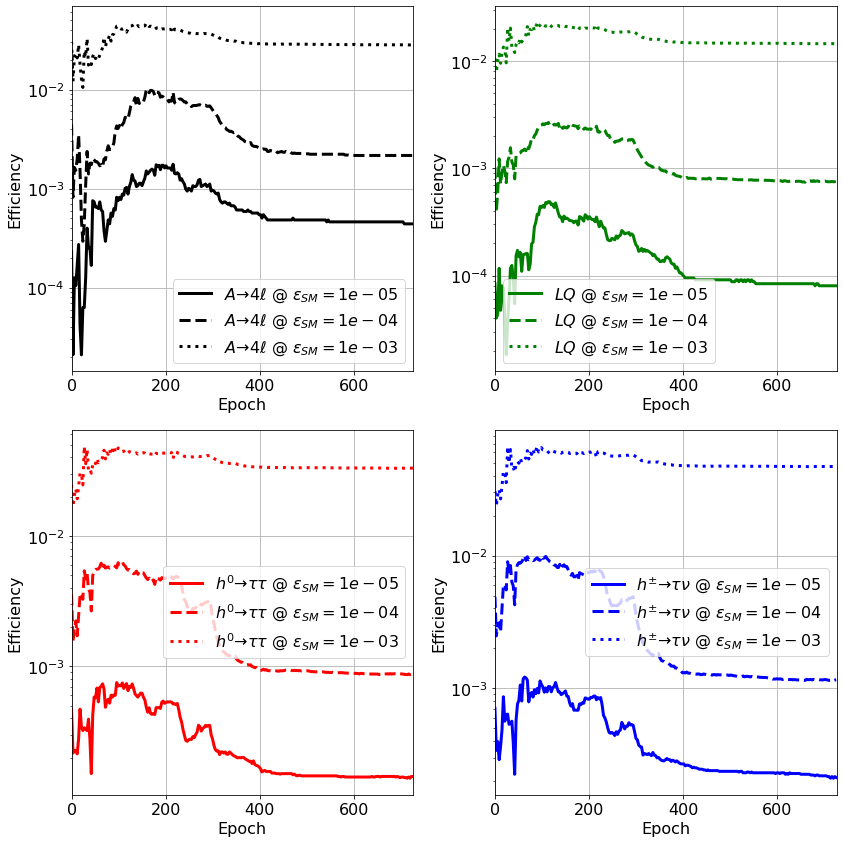

In [28]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

In [38]:
model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_epoch200.pkl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Convergence check

In [39]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

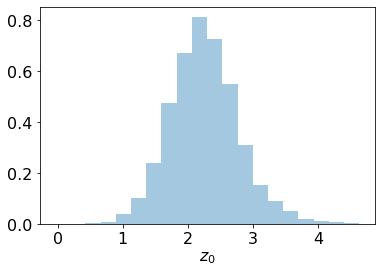

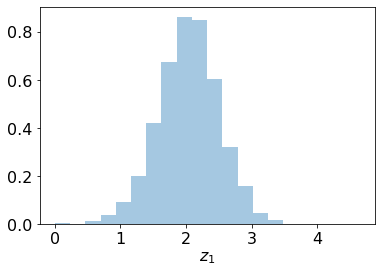

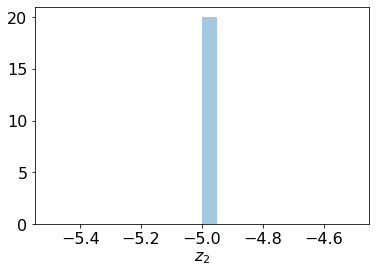

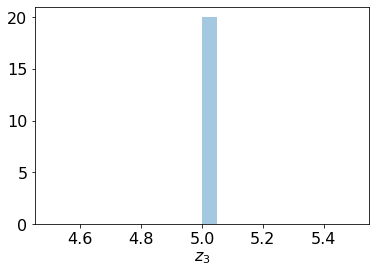

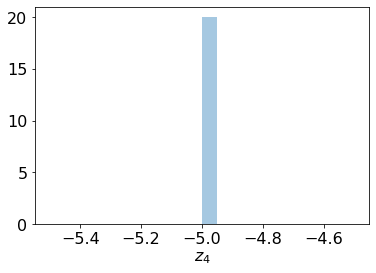

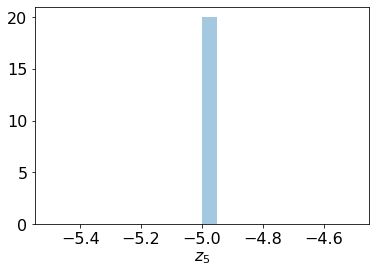

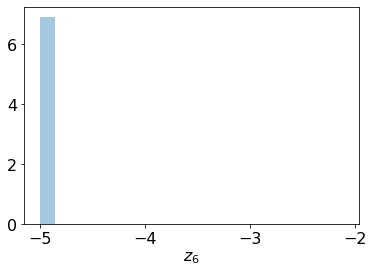

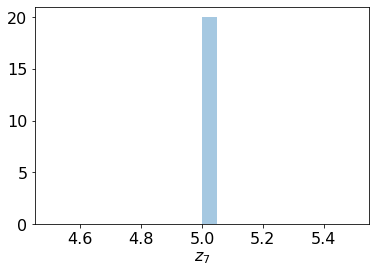

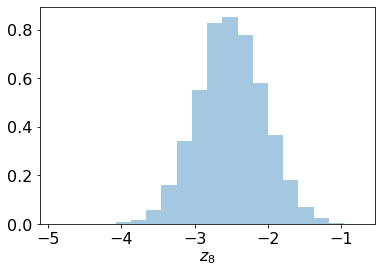

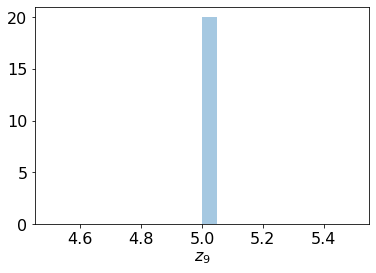

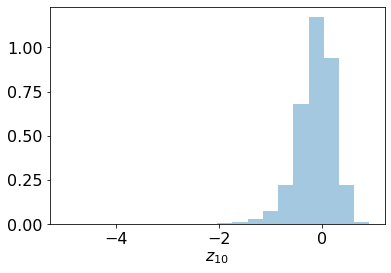

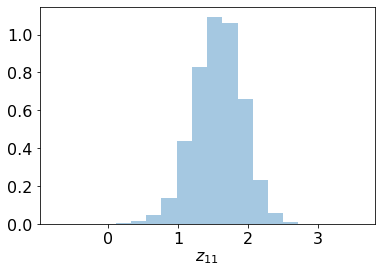

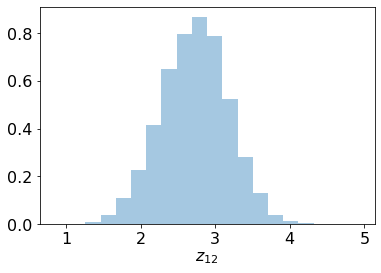

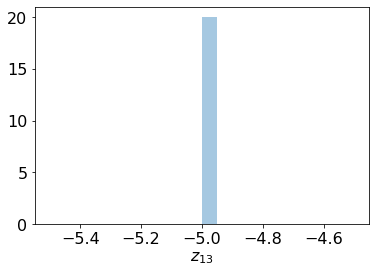

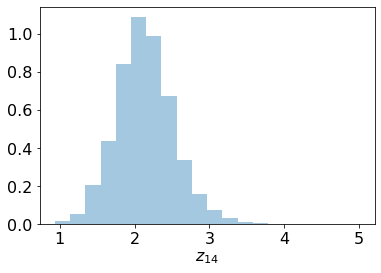

In [40]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

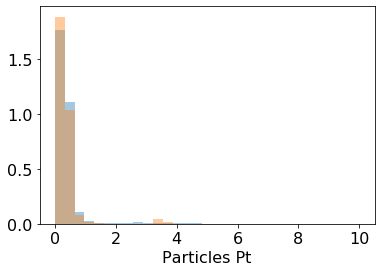

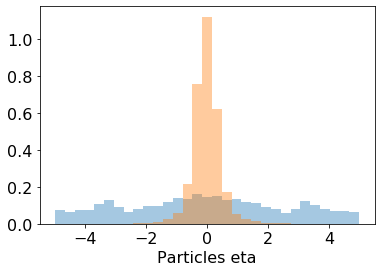

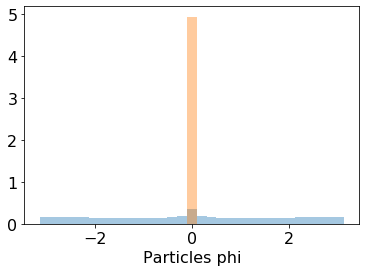

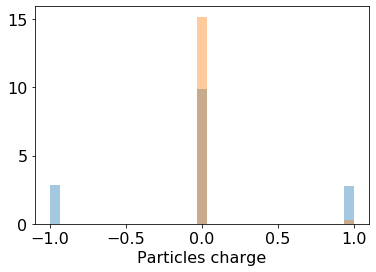

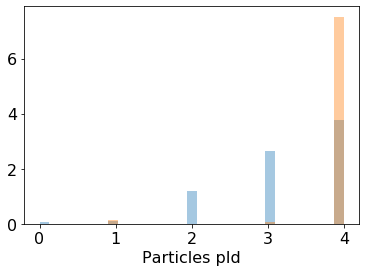

In [41]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
#     plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [33]:
dataset.loadValidationSamples('SM')

Loading Wlnu (2000.0k)
Loading qcd (1141.9k)
Loading Zll (773.6k)
Loading ttbar (989.9k)
SM Mix limiting stat. sample: qcd (1.14M)
SM validation weights
[('Wlnu', 0.99999921893491114253), ('qcd', 1.0), ('Zll', 0.29257605781977745954), ('ttbar', 0.010238898454774046649)]


In [44]:
model.eval()
for n in list(dataset.valSamples.keys()) + ['SMMix']:
    dataset.loss[n] = np.zeros((0))
    if n == 'SMMix':
        dataset.charge(dataset.SMMix_val)
    else:
        dataset.charge(dataset.valSamples[n])
    
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 4.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
Wlnu: [####################]  100% - Tot. time: 14.3 s
qcd: [####################]  100% - Tot. time: 7.3 s
Zll: [################]  100% - Tot. time: 4.7 s
ttbar: [####################]  100% - Tot. time: 6.4 s
SMMix: [####################]  100% - Tot. time: 24.6 s


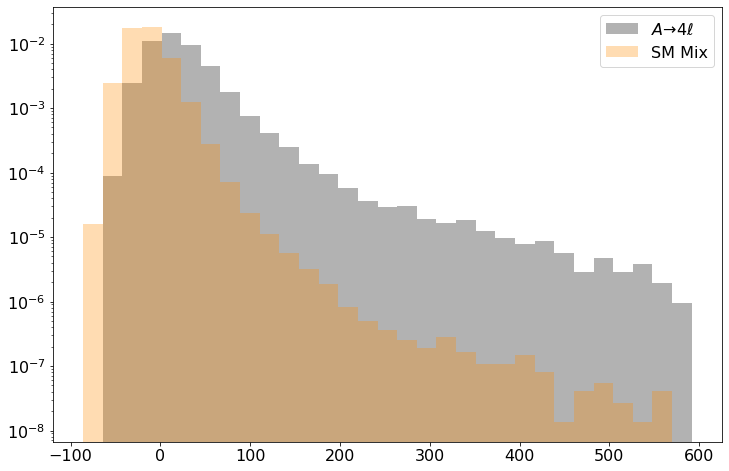

In [45]:
plt.figure(figsize=(12,8))
ra = np.array(list(map(lambda x: [np.min(x), np.quantile(x, 1-1e-3)], dataset.loss.values())))
r = (np.min(ra[:,0]), np.max(ra[:,1]))

for n in ['Ato4l','SMMix']:
    plt.hist(dataset.loss[n], bins=31, range=r,
             density=True,
             color=dataset.process_colors[n], 
             alpha=0.3, 
             label=dataset.process_labels[n])
plt.yscale('log')
plt.legend(loc='best')

In [42]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

CumSum accuracy: 1.000000000000026508


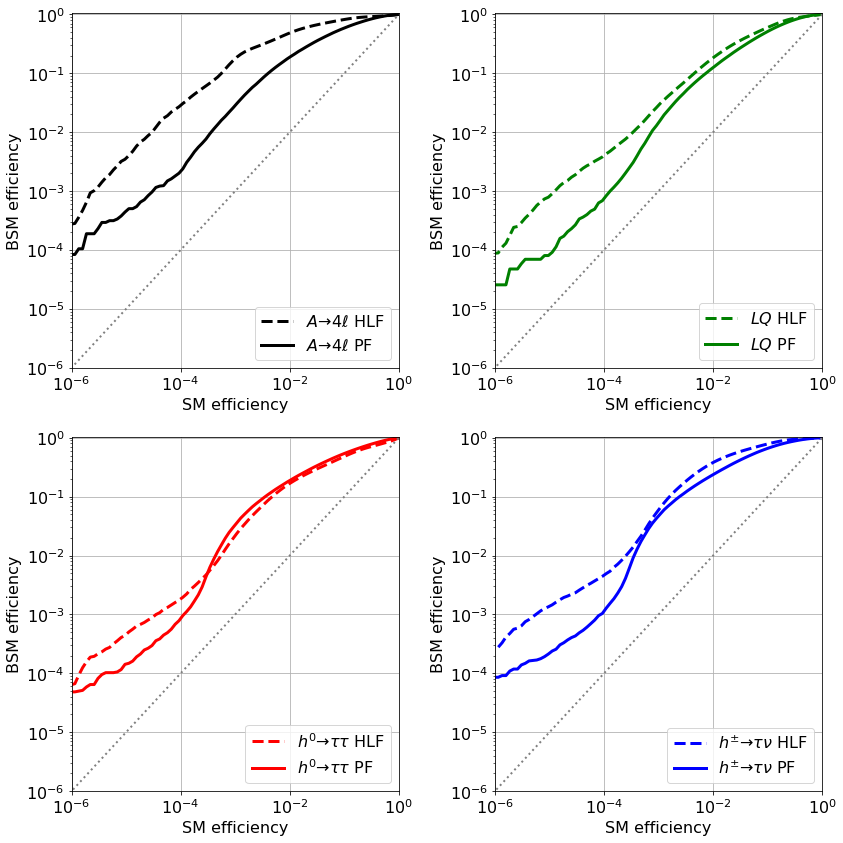

In [43]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [ ]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

In [ ]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()